In [1]:
# jupyter setup boilerplate
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from tqdm.auto import tqdm

from qick import *

# for now, all the tProc v2 classes need to be individually imported (can't use qick.*)

# the main program class
from qick.asm_v2 import AveragerProgramV2
# for defining sweeps
from qick.asm_v2 import QickSweep1D
# for adding code snippets in loop exec_before/exec_after
from qick.asm_v2 import AsmV2

In [2]:
from qick.pyro import make_proxy
soc, soccfg = make_proxy(ns_host="pynq216-6.dhcp.fnal.gov", ns_port=8888, proxy_name="myqick")
print(soccfg)

QICK library version mismatch: 0.2.283 remote (the board), 0.2.286 local (the PC)
                        This may cause errors, usually KeyError in QickConfig initialization.
                        If this happens, you must bring your versions in sync.


Pyro.NameServer PYRO:Pyro.NameServer@0.0.0.0:8888
myqick PYRO:obj_57aee66b236647378bf1236a7f41bfe3@131.225.82.237:44069
QICK running on ZCU216, software version 0.2.283

Firmware configuration (built Fri Sep 13 20:50:31 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	16 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 16384 samples (1.709 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 0 is 0_228, on JHC1
	1:	axis_signal_gen_v6 - envelope memory 4096 samples (0.427 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 1 is 1_228, on JHC2
	2:	axis_signal_gen_v6 - envelope memory 8192 samples (0.855 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 2 is 2_228, on JHC1
	3:	axis_signal_gen_v6 - envelope memory 4096 samples (0.427 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 3 is

In [3]:
# 0_228 -> 0_226 through DC-blocks (fullspeed gen to dyn RO)
# 0_229 -> 1_226 through "5-6 GHz" baluns (mux gen to mux RO)
# 1_229 and 3_229 -> scope ch. 1 and 2 through "10 MHz-1 GHz" baluns (bigenv int gens)
# 2_229 -> 2_226 through DC-blocks (int gen to dyn RO)

FSGEN_CH = [0, 2]
DYNRO_CH = [0, 1]
INTGEN_CH = [5, 7, 6]

MIXMUXGEN_CH = 4
MUXRO_CH = [2,3,4,5,6,7,8,9]

## RF-DAC and RF-ADC behavior
We connect a generator and readout through broadband DC-blocks, to see the full frequency response of the RF-DAC and RF-ADC.

(The program actually plays the same waveform through two generators, so you could look at one on a scope.)

In [4]:
from numpy.fft import rfft, fftshift, fftfreq
from scipy.signal import welch

def plot_fft(real_mr, t, fs, f=0):
    freqs, psd = welch(real_mr, fs, return_onesided=True, nperseg=256, detrend=False)
    power = 10*np.log10(psd)

    nqz = 1+np.floor(2*f/fs)
    nqz_sign = (-1)**(1 + nqz%2)
    freqs = ((nqz)//2)*fs + nqz_sign*freqs
    
    plt.plot(freqs, power)
    
    plt.xlabel("frequency [MHz]")
    plt.ylabel("power [arb. dB]")
    if f!=0: plt.axvline(f, color='pink')

class RawProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_chs = cfg['gen_chs']

        for gen_ch in cfg['gen_chs']:
            self.declare_gen(ch=gen_ch, nqz=cfg['nqz'])
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch,
                              outsel='input'
                              )
        self.add_pulse(ch=cfg['gen_chs'][0], name="mypulse", ro_ch=ro_ch, 
                       style="const", 
                       freq=cfg['freq'], 
                       length=cfg['pulse_len'],
                       phase=0,
                       gain=cfg['gain'], 
                      )
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        
    def _body(self, cfg):
        for gen_ch in cfg['gen_chs']:
            self.pulse(ch=gen_ch, name="mypulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])
        # trigger the MR buffer a little later so it starts recording after the pulse starts
        self.trigger(ddr4=True, mr=True, t=cfg['trig_time']+0.5)

config = {
          'gen_chs': FSGEN_CH,
          'ro_ch': DYNRO_CH[0],
          'freq': 100,
          'nqz': 1,
          'trig_time': 0.2,
          'ro_len': 10,
          'pulse_len': 9.5,
          'gain': 0.1,
         }

# look up the generator and readout sampling frequencies
gen_fs = soccfg['gens'][config['gen_chs'][0]]['fs']
ro_fs = soccfg['readouts'][config['ro_ch']]['fs']

Play a low-frequency signal and look at 5 cycles of the raw ADC samples: we see it clearly.

  0%|          | 0/1 [00:00<?, ?it/s]

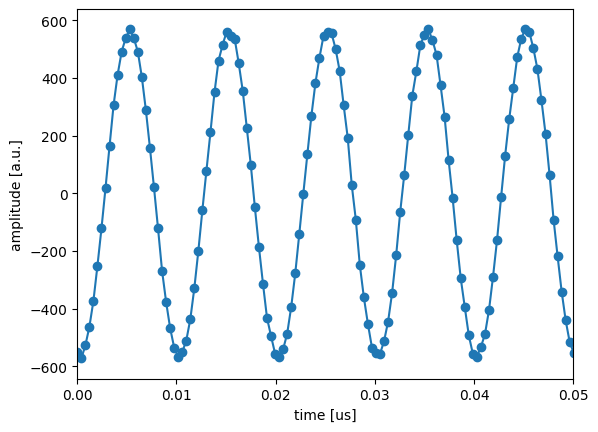

In [5]:
prog = RawProgram(soccfg, reps=1, final_delay=1.0, cfg=config)
soc.arm_mr(ch=config['ro_ch'])
prog.run_rounds(soc)

real_mr = soc.get_mr()[:,0]/4
t = prog.get_time_axis_mr(ro_ch=config['ro_ch'], data=real_mr)

plt.plot(t, real_mr, marker='o')
plt.xlabel("time [us]")
plt.ylabel("amplitude [a.u.]")
plt.xlim([0,5/config['freq']]);

Take the FFT, and we see the signal we generated.

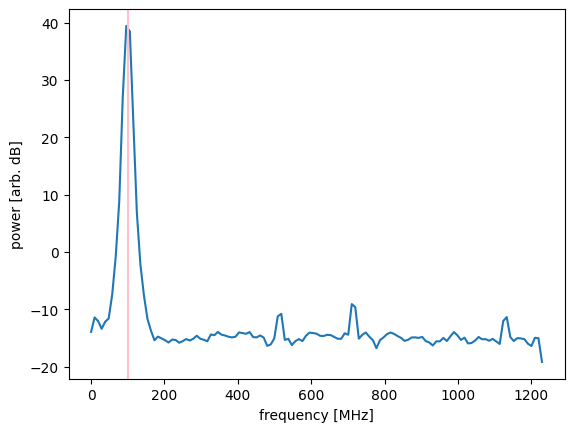

In [6]:
plot_fft(real_mr, t, ro_fs, config['freq'])

Now let's play something above the ADC's Nyquist frequency. Again the plot range is 5 cycles; it doesn't look right.

  0%|          | 0/1 [00:00<?, ?it/s]

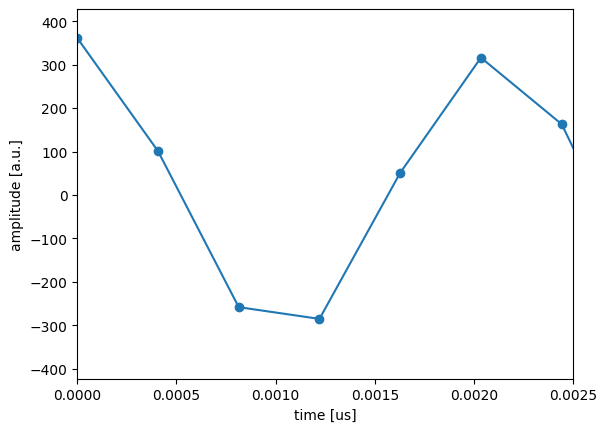

In [7]:
config['freq'] = 2000
prog = RawProgram(soccfg, reps=1, final_delay=1.0, cfg=config)
soc.arm_mr(ch=config['ro_ch'])
prog.run_rounds(soc)

real_mr = soc.get_mr()[:,0]/4
t = prog.get_time_axis_mr(ro_ch=config['ro_ch'], data=real_mr)

fig = plt.figure()
plt.plot(t, real_mr, marker='o')
plt.xlabel("time [us]")
plt.ylabel("amplitude [a.u.]")
plt.xlim([0,5/config['freq']]);

The FFT shows a peak, but not at any recognizable frequency.

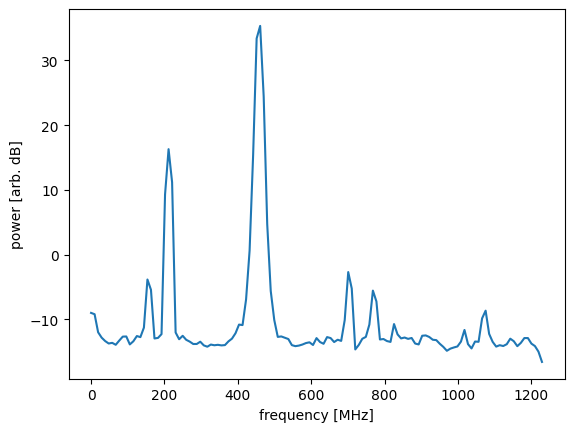

In [8]:
plot_fft(real_mr, t, ro_fs, 0)

But this is just Nyquist aliasing; the ADC isn't sampling fast enough to get multiple samples per cycle.
The bandwidth of the ADC is much higher than the sampling rate, so the samples still do a good job of capturing the fast waveform.

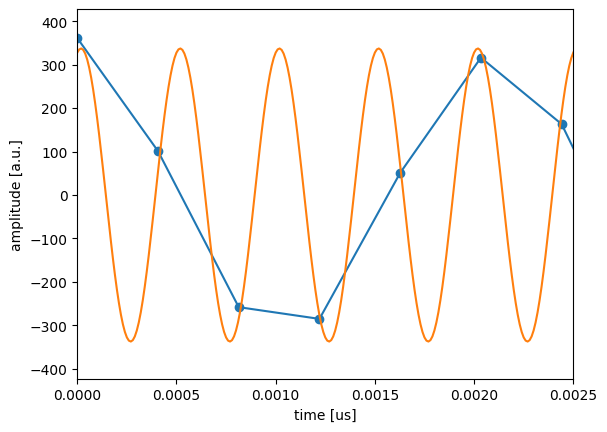

In [9]:
plot = fig.axes[0]
iq_mean = 2*np.mean(real_mr / np.exp(2j*np.pi*config['freq']*t))
t_fine = np.linspace(0,1,100000)
waveform_fine = np.real(iq_mean*np.exp(2j*np.pi*config['freq']*t_fine))
plot.plot(t_fine, waveform_fine)
fig

Similarly, the FFT peak makes sense if you understand that it's in the second Nyquist zone.

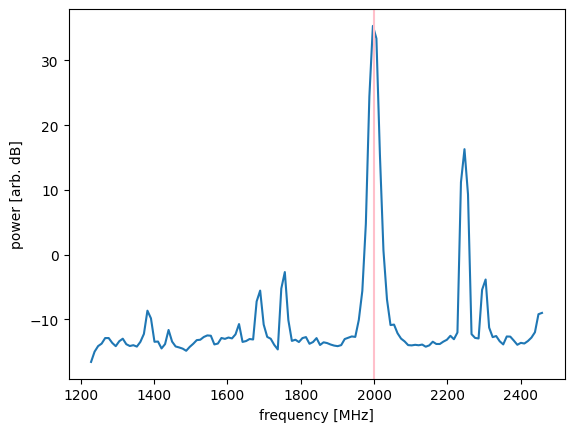

In [10]:
plot_fft(real_mr, t, ro_fs, config['freq'])

What is the second-highest peak, at ~2250 MHz?

This is the image frequency in the DAC's 2nd Nyquist zone; this is in the ADC's 7th Nyquist zone, but the ADC can still see it.

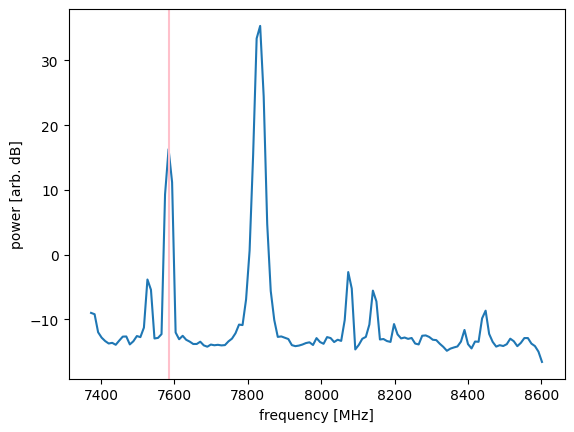

In [11]:
plot_fft(real_mr, t, ro_fs, gen_fs-config['freq'])

Switching the DAC to "mix-mode" boosts the power near the sampling frequency. (see https://docs.amd.com/r/en-US/pg269-rf-data-converter/RF-DAC-Nyquist-Zone-Operation)

In a realistic measurement, you would also use RF filters (like those built into the new "QICK box" frontend) to block the unwanted Nyquist images:
* filter the DAC to let through only one of the peaks
* filter the ADC to block noise from the other ADC Nyquist zones


  0%|          | 0/1 [00:00<?, ?it/s]

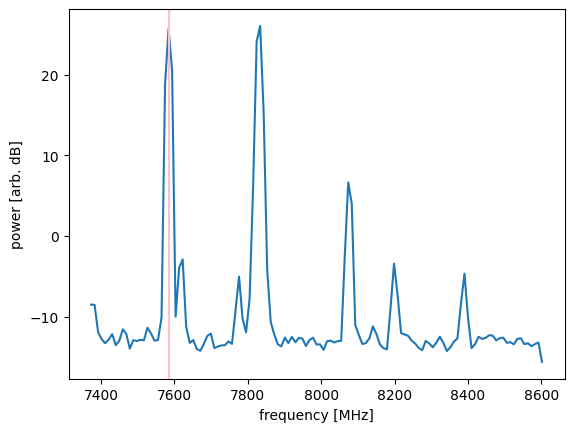

In [12]:
config['nqz'] = 2

prog = RawProgram(soccfg, reps=1, final_delay=1.0, cfg=config)
soc.arm_mr(ch=config['ro_ch'])
prog.run_rounds(soc)
real_mr = soc.get_mr()[:,0]/4
t = prog.get_time_axis_mr(ro_ch=config['ro_ch'], data=real_mr)

plot_fft(real_mr, t, ro_fs, gen_fs-config['freq'])

On a fast scope: ch. 1 on one side of a differential DAC output, ch. 3 on a low-frequency balun, ch.4 and trigger on the 0th digital output.

The horizontal scale is set so 1 div (100 ps) is approximately equal to the DAC sampling period.
You can get a sense that the DAC output is really a stairstep approximation to the sine wave.
The balun filters out the higher-frequency Nyquist images and gives you a cleaner 2 GHz.

![image.png](rfdac_sampling.png)

In [13]:
config['nqz'] = 1
config['gain'] = 1.0

prog = RawProgram(soccfg, reps=1, final_delay=1.0, cfg=config)
prog.run_rounds(soc)

  0%|          | 0/1 [00:00<?, ?it/s]

### Frequency sweep
Now let's do a frequency sweep.

First we'll calibrate the phase delay between the digital LOs of the generator and readout - this is not really important in this case, but would be useful in e.g. resonator spectroscopy.

  0%|          | 0/1 [00:00<?, ?it/s]

phase delay -179.8504 us


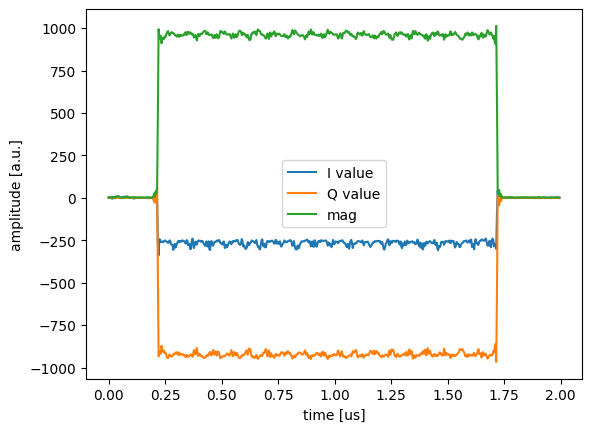

In [14]:
class FreqSweepProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'])
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        # we need to make sure the readout gets reconfigured at the start of each frequency step
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch)
        loopbefore = AsmV2()
        # if you delay the config by too long, you can see the readout get reconfigured in the middle of your pulse
        loopbefore.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)

        self.add_loop("myloop", self.cfg["steps"], exec_before=loopbefore)

        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
                       style="const", 
                       freq=cfg['freq'], 
                       length=cfg['pulse_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'], 
                      )
        
    def _body(self, cfg):
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

CAL_FREQ = 4000
CAL_RANGE = 0.1
DEBUG_CAL = False

# plot decimated to show that we're timed in
config = {'steps': 1,
          'gen_ch': FSGEN_CH[0],
          'ro_ch': DYNRO_CH[0],
          'freq': CAL_FREQ,
          'nqz': 1,
          'trig_time': 0.2,
          'ro_len': 2,
          'pulse_len': 1.5,
          'phase': 0,
          'gain': 1.0,
         }

prog = FreqSweepProgram(soccfg, reps=1, final_delay=1.0, cfg=config)
iq_list = prog.acquire_decimated(soc, soft_avgs=1)
t = prog.get_time_axis(ro_index=0)

iq = iq_list[0]
plt.plot(t, iq[:,0], label="I value")
plt.plot(t, iq[:,1], label="Q value")
plt.plot(t, np.abs(iq.dot([1,1j])), label="mag")
plt.ylabel("amplitude [a.u.]")
plt.xlabel("time [us]")
plt.legend();

def fit_delay(freqs, iqs, initial_delay=0, debug=False):
    iq_complex = iqs.dot([1,1j])

    # apply the initial correction
    iq_complex *= np.exp(-1j*freqs*2*np.pi*initial_delay)
    phases = np.unwrap(np.angle(iq_complex))/(2*np.pi)
    # phases = phases - (freqs)*initial_delay
    
    if debug: print("phase step after initial correction (cycles):", phases[1]-phases[0])
    
    # if debug:
    #     plt.plot(freqs, phases)
    #     plt.ylabel("Phase [cycles]")
    #     plt.xlabel("Frequency [MHz]")
    
    a = np.vstack([freqs, np.ones_like(freqs)]).T
    phase_delay = np.linalg.lstsq(a, phases, rcond=None)[0][0]
    total_delay = initial_delay + phase_delay
    if debug: print("delay correction %.4f us, new delay %.4f us"%(phase_delay, total_delay))
    return total_delay

# increase the pulse and RO length for more efficient measurement, and put the RO window inside the pulse
config['trig_time']+=0.5
config['pulse_len'] = 10
config['ro_len'] = 9.5

config['steps']=1001
config['freq'] = QickSweep1D("myloop",  CAL_FREQ, CAL_FREQ+CAL_RANGE)
prog = FreqSweepProgram(soccfg, reps=10, final_delay=1.0, cfg=config)
freqs = prog.get_pulse_param('myro', 'freq', as_array=True)
iq_list = prog.acquire(soc, soft_avgs=1, progress=False)
delay_cal = fit_delay(freqs, iq_list[0][0], debug=DEBUG_CAL)

config['steps']=1001
config['freq'] = QickSweep1D("myloop",  CAL_FREQ, CAL_FREQ+100*CAL_RANGE)
prog = FreqSweepProgram(soccfg, reps=10, final_delay=1.0, cfg=config)
freqs = prog.get_pulse_param('myro', 'freq', as_array=True)
iq_list = prog.acquire(soc, soft_avgs=1, progress=False)
delay_cal = fit_delay(freqs, iq_list[0][0], debug=DEBUG_CAL, initial_delay=delay_cal)
print("phase delay %.4f us"%(delay_cal))

The transfer function has a zero at the DAC sampling frequency.
This is an effect of the "zero-order hold" DAC in normal mode.

  0%|          | 0/100010 [00:00<?, ?it/s]

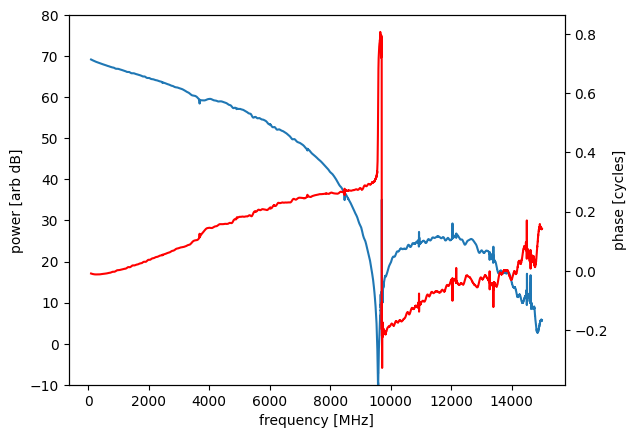

In [15]:
config['freq'] = QickSweep1D("myloop", 100, 15000)
config['steps'] = 10001
config['nqz'] = 1

prog = FreqSweepProgram(soccfg, reps=10, final_delay=1.0, cfg=config)
freqs = prog.get_pulse_param('myro', 'freq', as_array=True)
iq_list = prog.acquire(soc, soft_avgs=1, progress=True)
iq_complex = iq_list[0][0].dot([1,1j])

iq_rotated = iq_complex*np.exp(-1j*freqs*2*np.pi*delay_cal)

phases_corrected = np.unwrap(np.angle(iq_rotated))/(2*np.pi)
powers = 20*np.log10(np.abs(iq_rotated))

fig = plt.figure()
plt.plot(freqs, powers, label="amplitude [dB]")
plot = fig.axes[0]
ax2 = plot.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(freqs, phases_corrected, color='red', label='phase')

plot.set_ylim((-10, 80))
plot.set_ylabel("power [arb dB]")
plot.set_xlabel("frequency [MHz]")
ax2.set_ylabel("phase [cycles]");

Again, switching the DAC to "mix-mode" boosts the power near the sampling frequency.

  0%|          | 0/100010 [00:00<?, ?it/s]

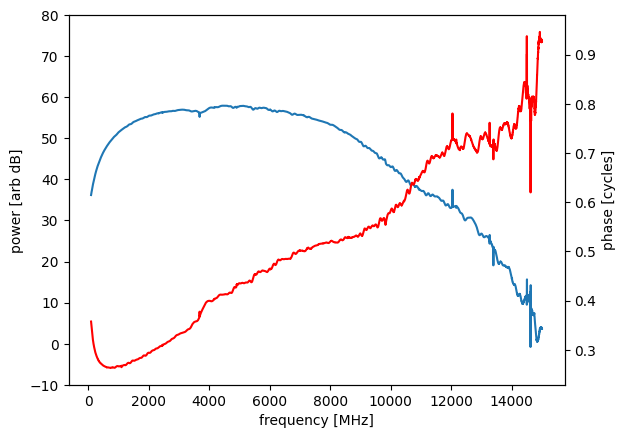

In [16]:
config['nqz'] = 2

prog = FreqSweepProgram(soccfg, reps=10, final_delay=1.0, cfg=config)
freqs = prog.get_pulse_param('myro', 'freq', as_array=True)
iq_list = prog.acquire(soc, soft_avgs=1, progress=True)
iq_complex = iq_list[0][0].dot([1,1j])

iq_rotated = iq_complex*np.exp(-1j*freqs*2*np.pi*delay_cal)

phases_corrected = np.unwrap(np.angle(iq_rotated))/(2*np.pi)
powers = 20*np.log10(np.abs(iq_rotated))

fig = plt.figure()
plt.plot(freqs, powers, label="amplitude [dB]")
plot = fig.axes[0]
ax2 = plot.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(freqs, phases_corrected, color='red', label='phase')

plot.set_ylim((-10, 80))
plot.set_ylabel("power [arb dB]")
plot.set_xlabel("frequency [MHz]")
ax2.set_ylabel("phase [cycles]");

## Phase control
Let's play a series of pulses on one generator, playing a continuous tone on a second generator as a reference. You can imagine that we're playing qubit control pulses and the reference represents the qubit reference frame.

The sequence we play is: two pulses at phase 0 (X gates), one pulse at 180 degrees (-X gate), one pulse at 90 degrees (Y gate).

The generator behaves much like an IQ mixer with a reference LO. The difference is that here, the reference LO and the mixing are purely digital, so their behavior is close to ideal and no calibration is needed.

Note:
* The phase of each pulse is defined relative to the reference, not the pulse envelope. This "phase coherence" is what you need for qubit control.
* Since the reference maintains its phase between shots and runs, the start times of the pulses do not have a predictable relationship to the reference phase.

In [17]:
class TwoChProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_chs = cfg['ro_chs']
        # gen_chs = cfg['gen_chs']

        for gen_ch in [cfg['gen_ch1'], cfg['gen_ch2']]:
            self.declare_gen(ch=gen_ch, nqz=cfg['nqz'], mixer_freq=0)
        for ro_ch in ro_chs:
            self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        # we can use the same config for the two readouts
        self.add_readoutconfig(ch=ro_chs[0], name="myro", freq=cfg['freq'], gen_ch=cfg['gen_ch1'])

        self.add_pulse(ch=cfg['gen_ch2'], name="refpulse", ro_ch=ro_chs[0], 
                       style="const", 
                       freq=cfg['freq'], 
                       length=10.0,
                       phase=0,
                       gain=0.2*cfg['gain'], 
                      )
        for ph in [0, 90, 180]:
            self.add_pulse(ch=cfg['gen_ch1'], name="mypulse%d"%(ph), ro_ch=ro_chs[0], 
                           style="const", 
                           freq=cfg['freq'], 
                           length=cfg['pulse_len'],
                           phase=ph,
                           gain=cfg['gain'], 
                          )
        
        for ro_ch in ro_chs:
            self.send_readoutconfig(ch=ro_ch, name="myro", t=0)
        
    def _body(self, cfg):
        # get the reference waveform started early
        self.pulse(ch=cfg['gen_ch2'], name="refpulse", t=0)
        self.delay(1.0)
        
        self.trigger(ros=cfg['ro_chs'], t=cfg['trig_time']) # readout trigger
        self.trigger(pins=[0], t=0.1) # marker pulse
        self.pulse(ch=cfg['gen_ch1'], name="mypulse0", t=0)
        self.delay(1.5*cfg['pulse_len'])
        self.pulse(ch=cfg['gen_ch1'], name="mypulse0", t=0)
        self.delay(1.5*cfg['pulse_len'])
        self.pulse(ch=cfg['gen_ch1'], name="mypulse180", t=0)
        self.delay(1.5*cfg['pulse_len'])
        self.pulse(ch=cfg['gen_ch1'], name="mypulse90", t=0)

config = {'gen_ch1': INTGEN_CH[0],
          'gen_ch2': INTGEN_CH[1],
          'ro_chs': DYNRO_CH,
          'freq': 50,
          'nqz': 1,
          'trig_time': 0.4,
          'ro_len': 0.5,
          'pulse_len': 0.06,
          'phase': 0,
          'gain': 1.0
         }

prog = TwoChProgram(soccfg, reps=10, final_delay=5e5, cfg=config)
prog.run_rounds(soc)

  0%|          | 0/10 [00:00<?, ?it/s]

We can change the generator frequency on the fly, playing a series of pulses at different frequencies.

Note:
* When we return to the original frequency, we also return to the original phase. Consider also that the two generators are maintaining identical phase and will never slip. This is the advantage of digitally synthesized oscillators.
* There's no difficulty playing these pulses back-to-back without gaps.

In [18]:
class TwoChProgram2(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_chs = cfg['ro_chs']
        # gen_chs = cfg['gen_chs']

        for gen_ch in [cfg['gen_ch1'], cfg['gen_ch2']]:
            self.declare_gen(ch=gen_ch, nqz=cfg['nqz'], mixer_freq=0)
        for ro_ch in ro_chs:
            self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        # we can use the same config for the two readouts
        self.add_readoutconfig(ch=ro_chs[0], name="myro", freq=cfg['freq'], gen_ch=cfg['gen_ch1'])

        self.add_pulse(ch=cfg['gen_ch2'], name="refpulse", ro_ch=ro_chs[0], 
                       style="const", 
                       freq=cfg['freq'], 
                       length=10.0,
                       phase=0,
                       gain=0.2*cfg['gain'], 
                      )
        for ph in [0, 90, 180]:
            self.add_pulse(ch=cfg['gen_ch1'], name="mypulse%d"%(ph), ro_ch=ro_chs[0], 
                           style="const", 
                           freq=cfg['freq'], 
                           length=cfg['pulse_len'],
                           phase=ph,
                           gain=cfg['gain'], 
                          )
        self.add_pulse(ch=cfg['gen_ch1'], name="mypulsejump", ro_ch=ro_chs[0], 
                       style="const", 
                       freq=2*cfg['freq'], 
                       length=cfg['pulse_len'],
                       phase=ph,
                       gain=cfg['gain'], 
                      )
        
        for ro_ch in ro_chs:
            self.send_readoutconfig(ch=ro_ch, name="myro", t=0)
        
    def _body(self, cfg):
        # get the reference waveform started early
        self.pulse(ch=cfg['gen_ch2'], name="refpulse", t=0)
        self.delay(1.0)
        
        self.trigger(ros=cfg['ro_chs'], t=cfg['trig_time']) # readout trigger
        self.trigger(pins=[0], t=0.1) # marker pulse
        self.pulse(ch=cfg['gen_ch1'], name="mypulse0", t=0)
        self.delay(cfg['pulse_len'])
        self.pulse(ch=cfg['gen_ch1'], name="mypulsejump", t=0)
        self.delay(cfg['pulse_len'])
        self.pulse(ch=cfg['gen_ch1'], name="mypulse0", t=0)
        self.delay(cfg['pulse_len'])
        self.pulse(ch=cfg['gen_ch1'], name="mypulse180", t=0)

config = {'gen_ch1': INTGEN_CH[0],
          'gen_ch2': INTGEN_CH[1],
          'ro_chs': DYNRO_CH,
          'freq': 50,
          'nqz': 1,
          'trig_time': 0.4,
          'ro_len': 0.5,
          'pulse_len': 0.06,
          'phase': 0,
          'gain': 1.0
         }

prog = TwoChProgram2(soccfg, reps=10, final_delay=5e5, cfg=config)
prog.run_rounds(soc)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

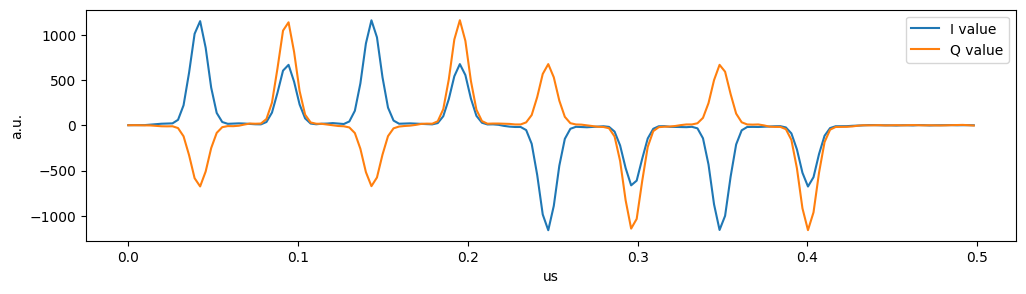

In [19]:
from qick.asm_v2 import AsmV2
class PulseSequenceProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])
                # we can use the same config for the two readouts
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch)


        pulse_len = cfg['pulse_len']
        self.add_gauss(ch=gen_ch, name="gauss", sigma=pulse_len/10, length=pulse_len, even_length=True)
        
        self.add_pulse(ch=gen_ch, name="x/2", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="gauss", 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1.0, 
                      )
        self.add_pulse(ch=gen_ch, name="y/2", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="gauss", 
                       freq=cfg['freq'], 
                       phase=90,
                       gain=1.0, 
                      )
        self.add_pulse(ch=gen_ch, name="-x/2", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="gauss", 
                       freq=cfg['freq'], 
                       phase=180,
                       gain=1.0, 
                      )
        self.add_pulse(ch=gen_ch, name="-y/2", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="gauss", 
                       freq=cfg['freq'], 
                       phase=270,
                       gain=1.0, 
                      )

        self.send_readoutconfig(ch=ro_ch, name="myro", t=0)
    
    
    def _body(self, cfg):
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

        self.pulse(ch=cfg['gen_ch'], name="x/2", t=0)
        self.delay(cfg['pulse_len'])
        self.pulse(ch=cfg['gen_ch'], name="y/2", t=0)
        self.delay(cfg['pulse_len'])
        self.pulse(ch=cfg['gen_ch'], name="x/2", t=0)
        self.delay(cfg['pulse_len'])
        self.pulse(ch=cfg['gen_ch'], name="y/2", t=0)
        self.delay(cfg['pulse_len'])
        self.pulse(ch=cfg['gen_ch'], name="-x/2", t=0)
        self.delay(cfg['pulse_len'])
        self.pulse(ch=cfg['gen_ch'], name="-y/2", t=0)
        self.delay(cfg['pulse_len'])
        self.pulse(ch=cfg['gen_ch'], name="-x/2", t=0)
        self.delay(cfg['pulse_len'])
        self.pulse(ch=cfg['gen_ch'], name="-y/2", t=0)
        self.delay(cfg['pulse_len'])
        
        
config = {'gen_ch': FSGEN_CH[0],
          'ro_ch': DYNRO_CH[0],
          'freq': 200,
          'trig_time': 0.4,
          'ro_len': 0.5,
          'pulse_len': 0.05,
         }

prog = PulseSequenceProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=1)
t = prog.get_time_axis(ro_index=0)

fig = plt.figure(figsize=(12,3))

iq = iq_list[0]
plt.plot(t, iq[:,0], label="I value")
plt.plot(t, iq[:,1], label="Q value")
# plt.plot(t, np.abs(iq.dot([1,1j])), label="magnitude")
plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us");

In [20]:
print(prog)

macros:
	WriteReg(dst='s_core_w1', src=0)
	ConfigReadout(ch=0, name='myro', t=0, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0x7fae85edd190>}, t_regs={'t': 0})
	Delay(t=1.0, auto=True, gens=True, ros=True, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0x7fae85ebe950>}, t_regs={'t': 430})
	OpenLoop(n=1, name='reps')
	Trigger(ros=[0], pins=[0], t=0.4, width=0.023251488095238096, ddr4=False, mr=False, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0x7fae85edd450>, 'width': <qick.asm_v2.QickParam object at 0x7fae85edd5d0>}, t_regs={'t': 172, 'width': 10}, outdict=defaultdict(<class 'int'>, {}), trigset={0, 10})
	Pulse(ch=0, name='x/2', t=0, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0x7fae85edd710>}, t_regs={'t': 0})
	Delay(t=0.05, auto=False, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0x7fae85edd8d0>}, t_regs={'t': 22})
	Pulse(ch=0, name='y/2', t=0, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0x7fae85edda10>}

  0%|          | 0/1 [00:00<?, ?it/s]

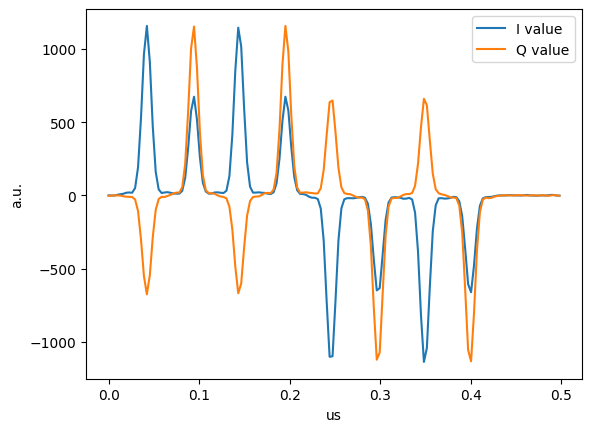

In [21]:
from qick.asm_v2 import AsmV2
class PulseUpdateProgram2(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])
                # we can use the same config for the two readouts
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch)


        pulse_len = cfg['pulse_len']
        self.add_gauss(ch=gen_ch, name="gauss", sigma=pulse_len/10, length=pulse_len)
        
        self.add_pulse(ch=gen_ch, name="x/2", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="gauss", 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1.0, 
                      )
        self.add_pulse(ch=gen_ch, name="y/2", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="gauss", 
                       freq=cfg['freq'], 
                       phase=90,
                       gain=1.0, 
                      )

        sub = AsmV2()
        sub.pulse(ch=cfg['gen_ch'], name="x/2", t=0)
        sub.delay(pulse_len)
        self.add_subroutine("play_x/2", sub)

        sub = AsmV2()
        sub.pulse(ch=cfg['gen_ch'], name="y/2", t=0)
        sub.delay(pulse_len)
        self.add_subroutine("play_y/2", sub)

        sub = AsmV2()
        for wname in self.list_pulse_waveforms("x/2")+self.list_pulse_waveforms("y/2"):
            sub.read_wmem(name=wname)
            sub.inc_reg(dst='w_phase', src=self.deg2reg(180, gen_ch=cfg['gen_ch']))
            sub.write_wmem(name=wname)
        self.add_subroutine("virt_z", sub)

        self.send_readoutconfig(ch=ro_ch, name="myro", t=0)
    
    
    def _body(self, cfg):
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

        self.call("play_x/2")
        self.call("play_y/2")
        self.call("play_x/2")
        self.call("play_y/2")
        self.call("virt_z")
        self.call("play_x/2")
        self.call("play_y/2")
        self.call("play_x/2")
        self.call("play_y/2")

        # reset the phase to 0
        for wname in self.list_pulse_waveforms("x/2"):
            self.read_wmem(name=wname)
            self.write_reg(dst='w_phase', src=0)
            self.write_wmem(name=wname)
        for wname in self.list_pulse_waveforms("y/2"):
            self.read_wmem(name=wname)
            self.write_reg(dst='w_phase', src=self.deg2reg(90, gen_ch=cfg['gen_ch']))
            self.write_wmem(name=wname)
        
config = {'gen_ch': FSGEN_CH[0],
          'ro_ch': DYNRO_CH[0],
          'freq': 200,
          'trig_time': 0.4,
          'ro_len': 0.5,
          'pulse_len': 0.05,
         }

prog = PulseUpdateProgram2(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=1)
t = prog.get_time_axis(ro_index=0)

# fig, axes = plt.subplots(len(iq_list[0]), 1, figsize=(10,6))

iq = iq_list[0]
plt.plot(t, iq[:,0], label="I value")
plt.plot(t, iq[:,1], label="Q value")
# plt.plot(t, np.abs(iq.dot([1,1j])), label="magnitude")
plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us");

In [22]:
print(prog)

macros:
	WriteReg(dst='s_core_w1', src=0)
	ConfigReadout(ch=0, name='myro', t=0, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0x7fae85d49ad0>}, t_regs={'t': 0})
	Delay(t=1.0, auto=True, gens=True, ros=True, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0x7fae85e96710>}, t_regs={'t': 430})
	OpenLoop(n=1, name='reps')
	Trigger(ros=[0], pins=[0], t=0.4, width=0.023251488095238096, ddr4=False, mr=False, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0x7fae85d0f4d0>, 'width': <qick.asm_v2.QickParam object at 0x7fae85d49d90>}, t_regs={'t': 172, 'width': 10}, outdict=defaultdict(<class 'int'>, {}), trigset={0, 10})
	AsmInst(inst={'CMD': 'CALL', 'LABEL': 'play_x/2'}, addr_inc=1)
	AsmInst(inst={'CMD': 'CALL', 'LABEL': 'play_y/2'}, addr_inc=1)
	AsmInst(inst={'CMD': 'CALL', 'LABEL': 'play_x/2'}, addr_inc=1)
	AsmInst(inst={'CMD': 'CALL', 'LABEL': 'play_y/2'}, addr_inc=1)
	AsmInst(inst={'CMD': 'CALL', 'LABEL': 'virt_z'}, addr_inc=1)
	AsmInst(inst={'CMD': 'CALL', 

  0%|          | 0/1 [00:00<?, ?it/s]

macros:
	WriteReg(dst='s_core_w1', src=0)
	ConfigReadout(ch=0, name='myro', t=0, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0x7fae85f17ed0>}, t_regs={'t': 0})
	Delay(t=1.0, auto=True, gens=True, ros=True, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0x7fae85d4f450>}, t_regs={'t': 430})
	OpenLoop(n=1, name='reps')
	Trigger(ros=[0], pins=[0], t=0.4, width=0.023251488095238096, ddr4=False, mr=False, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0x7fae85d474d0>, 'width': <qick.asm_v2.QickParam object at 0x7fae85f1a0d0>}, t_regs={'t': 172, 'width': 10}, outdict=defaultdict(<class 'int'>, {}), trigset={0, 10})
	Pulse(ch=0, name='x/2', t=0, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0x7fae85f1b6d0>}, t_regs={'t': 0})
	Delay(t=0.05, auto=False, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0x7fae8c35e2d0>}, t_regs={'t': 22})
	Pulse(ch=0, name='y/2', t=0, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0x7fae8c35d310>}

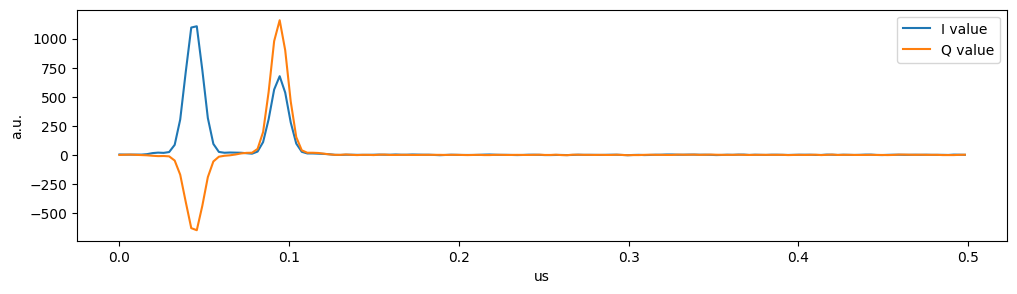

In [23]:
from qick.asm_v2 import AsmV2
class PulseSequenceProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])
                # we can use the same config for the two readouts
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch)


        pulse_len = cfg['pulse_len']
        self.add_gauss(ch=gen_ch, name="gauss", sigma=pulse_len/10, length=pulse_len, even_length=True)
        
        self.add_pulse(ch=gen_ch, name="x/2", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="gauss", 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1.0, 
                      )
        self.add_pulse(ch=gen_ch, name="y/2", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="gauss", 
                       freq=cfg['freq'], 
                       phase=90,
                       gain=1.0, 
                      )
        self.add_pulse(ch=gen_ch, name="-x/2", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="gauss", 
                       freq=cfg['freq'], 
                       phase=180,
                       gain=1.0, 
                      )
        self.add_pulse(ch=gen_ch, name="-y/2", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="gauss", 
                       freq=cfg['freq'], 
                       phase=270,
                       gain=1.0, 
                      )

        self.send_readoutconfig(ch=ro_ch, name="myro", t=0)
    
    
    def _body(self, cfg):
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

        self.pulse(ch=cfg['gen_ch'], name="x/2", t=0)
        self.delay(cfg['pulse_len'])
        self.pulse(ch=cfg['gen_ch'], name="y/2", t=0)
        self.delay(cfg['pulse_len'])
        
config = {'gen_ch': FSGEN_CH[0],
          'ro_ch': DYNRO_CH[0],
          'freq': 200,
          'trig_time': 0.4,
          'ro_len': 0.5,
          'pulse_len': 0.05,
         }

prog = PulseSequenceProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=1)
t = prog.get_time_axis(ro_index=0)

fig = plt.figure(figsize=(12,3))

iq = iq_list[0]
plt.plot(t, iq[:,0], label="I value")
plt.plot(t, iq[:,1], label="Q value")
# plt.plot(t, np.abs(iq.dot([1,1j])), label="magnitude")
plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us");

print(prog)

In [24]:
# # debug program to play pulses on every int4 gen

# class IntGenDynROProgram(AveragerProgramV2):
#     def _initialize(self, cfg):
#         ro_ch = cfg['ro_ch']
#         gen_chs = cfg['gen_chs']


#         for gen_ch in gen_chs:
#             self.declare_gen(ch=gen_ch, nqz=1, mixer_freq=cfg['mixer_freq'], ro_ch=ro_ch)
#         self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

#         self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['pulse_freq'], phase=cfg['ro_phase'], gen_ch=gen_chs[0])

#         # loopbefore = AsmV2()
#         # # if you delay the config by too long, you can see the readout get reconfigured in the middle of your pulse
#         # loopbefore.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
#         # self.add_loop("myloop", self.cfg["steps"], exec_before=loopbefore)
        
#         # self.add_gauss(ch=gen_ch, name="ramp", sigma=cfg['ramp_len']/10, length=cfg['ramp_len'], even_length=True)
#         self.add_pulse(ch=gen_chs[0], name="mypulse", ro_ch=ro_ch, 
#                        style="const", 
#                        # envelope="ramp", 
#                        freq=cfg['pulse_freq'], 
#                        length=cfg['flat_len'],
#                        phase=cfg['pulse_phase'],
#                        gain=cfg['pulse_gain'], 
#                       )

#         self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        
#     def _body(self, cfg):
#         self.trigger(pins=[0], t=cfg['trig_time'])
#         for gen_ch in cfg['gen_chs']:
#             self.pulse(ch=gen_ch, name="mypulse", t=0)
        
# config = {
#           # 'gen_chs': [4,5,6,7,8,9,10,11,13,14,15],
#           'gen_chs': [5,6,7,8,9,10,11,12,13,14,15],
#           'ro_ch': DYNRO_CH[0],
#           'pulse_freq': 0,
#           'mixer_freq': 0,
#           'pulse_phase': 0.0,
#           'pulse_gain': 1.0,
#           'ro_phase': 0.0,
#           'trig_time': 0.1,
#           'flat_len': 0.1,
#           'ramp_len': 0.2,
#           'ro_len': 0.3,
#          }

# prog = IntGenDynROProgram(soccfg, reps=100, final_delay=1e5, cfg=config)

# while True:
#     prog.run_rounds(soc, progress=False)

In [25]:
# class TwoChProgram(AveragerProgramV2):
#     def _initialize(self, cfg):
#         ro_chs = cfg['ro_chs']
#         gen_chs = cfg['gen_chs']

#         for gen_ch in gen_chs:
#             self.declare_gen(ch=gen_ch, nqz=cfg['nqz'])
#         for ro_ch in ro_chs:
#             self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

#         self.add_loop("myloop", self.cfg["steps"])
#         # we can use the same config for the two readouts
#         self.add_readoutconfig(ch=ro_chs[0], name="myro", freq=cfg['freq'], gen_ch=gen_chs[0])

#         for gen_ch in gen_chs:
#             self.add_gauss(ch=gen_ch, name="ramp", sigma=cfg['ramp_len']/10, length=cfg['ramp_len'], even_length=True)

#         self.add_pulse(ch=gen_chs[0], name="mypulse", ro_ch=ro_chs[0], 
#                        style="flat_top", 
#                        envelope="ramp", 
#                        freq=cfg['freq'], 
#                        length=cfg['flat_len'],
#                        phase=cfg['phase'],
#                        gain=cfg['gain'], 
#                       )

#         for ro_ch in ro_chs:
#             self.send_readoutconfig(ch=ro_ch, name="myro", t=0)
        
#     def _body(self, cfg):
#         for gen_ch in cfg['gen_chs']:
#             self.pulse(ch=gen_ch, name="mypulse", t=0)
#         self.trigger(ros=cfg['ro_chs'], pins=[0], t=cfg['trig_time'])


# config = {'steps': 1,
#           'gen_chs': FSGEN_CH,
#           'ro_chs': DYNRO_CH,
#           'freq': 200,
#           'nqz': 1,
#           'trig_time': 0.4,
#           'ro_len': 0.5,
#           'flat_len': 0.05,
#           'ramp_len': 0.2,
#           'phase': 0,
#           'gain': 1.0
#          }

# prog = TwoChProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

# iq_list = prog.acquire_decimated(soc, soft_avgs=1)
# t = prog.get_time_axis(ro_index=0)

# fig, axes = plt.subplots(len(config['ro_chs']), 1, figsize=(12,9))
# for i, ch in enumerate(config['ro_chs']):
#     plot = axes[i]
#     plot.plot(t, iq_list[i][:,0], label="I value")
#     plot.plot(t, iq_list[i][:,1], label="Q value")
#     plot.plot(t, np.abs(iq_list[i].dot([1,1j])), label="magnitude")
#     plot.legend()
#     plot.set_ylabel("a.u.")
#     plot.set_xlabel("us");


# # for ii, iq in enumerate(iq_list[0]):
# #     plt.plot(t, iq[:,0], label="I value, step %d"%(ii))
# #     # plt.plot(t, iq[:,1], label="Q value, step %d"%(ii))
# #     # plt.plot(t, np.abs(iq.dot([1,1j])), label="mag, step %d"%(ii))
# # plt.legend()
# # plt.ylabel("amplitude [ADU]")
# # plt.xlabel("time [us]");


In [26]:
# # for scope
# config['trig_time'] = 0.1
# prog = TwoChProgram(soccfg, reps=100, final_delay=1e5, cfg=config)

# iq_list = prog.acquire(soc, soft_avgs=1)
# # t = prog.get_time_axis(ro_index=0)
# # print(len(t))

In [27]:
# class SimpleSweepProgram2(AveragerProgramV2):
#     def _initialize(self, cfg):
#         ro_ch = cfg['ro_ch']
#         gen_ch = cfg['gen_ch']
        
#         self.declare_gen(ch=gen_ch, nqz=cfg['nqz'])
#         self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

#         self.add_loop("myloop", self.cfg["steps"])
#         self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch)

#         self.add_gauss(ch=gen_ch, name="ramp", sigma=cfg['ramp_len']/10, length=cfg['ramp_len'], even_length=True)
#         self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
#                        style="flat_top", 
#                        envelope="ramp", 
#                        freq=cfg['freq'], 
#                        length=cfg['flat_len'],
#                        phase=cfg['phase'],
#                        gain=cfg['gain'], 
#                       )

        
#         self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        
#     def _body(self, cfg):
#         self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)
#         self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

In [28]:
# # do a sweep with 5 points and plot decimated
# config = {'steps': 5,
#           'gen_ch': FSGEN_CH[0],
#           'ro_ch': DYNRO_CH[0],
#           'freq': 1500,
#           'nqz': 1,
#           'trig_time': 0.4,
#           'ro_len': 0.3,
#           'flat_len': 0.05,
#           'ramp_len': 0.2,
#           'phase': QickSweep1D("myloop", -360, 720),
#           'gain': QickSweep1D("myloop", 0.0, 1.0)
#          }

# prog = SimpleSweepProgram2(soccfg, reps=1, final_delay=0.5, cfg=config)

# iq_list = prog.acquire_decimated(soc, soft_avgs=1)
# t = prog.get_time_axis(ro_index=0)

# for ii, iq in enumerate(iq_list[0]):
#     plt.plot(t, iq[:,0], label="I value, step %d"%(ii))
#     # plt.plot(t, iq[:,1], label="Q value, step %d"%(ii))
#     # plt.plot(t, np.abs(iq.dot([1,1j])), label="mag, step %d"%(ii))
# plt.legend()
# plt.ylabel("amplitude [ADU]")
# plt.xlabel("time [us]");


## Multiplexed generator and readout
We connect the multiplexed generator to the multiplexed readout through a pair of high-frequency baluns.

First, we can define 8 tones at different frequencies and play them simultaneously.

(We run the program once with default tone phases, then use the measured phases to put every tone on the real axis.)

phase offsets: [np.float64(29.005872850344478), np.float64(-84.31062400312919), np.float64(162.20093114174654), np.float64(-75.41764346529108), np.float64(170.20279464756035), np.float64(-67.44507484956604), np.float64(-178.9171543304438), np.float64(69.46149516021723)]


  0%|          | 0/1 [00:00<?, ?it/s]

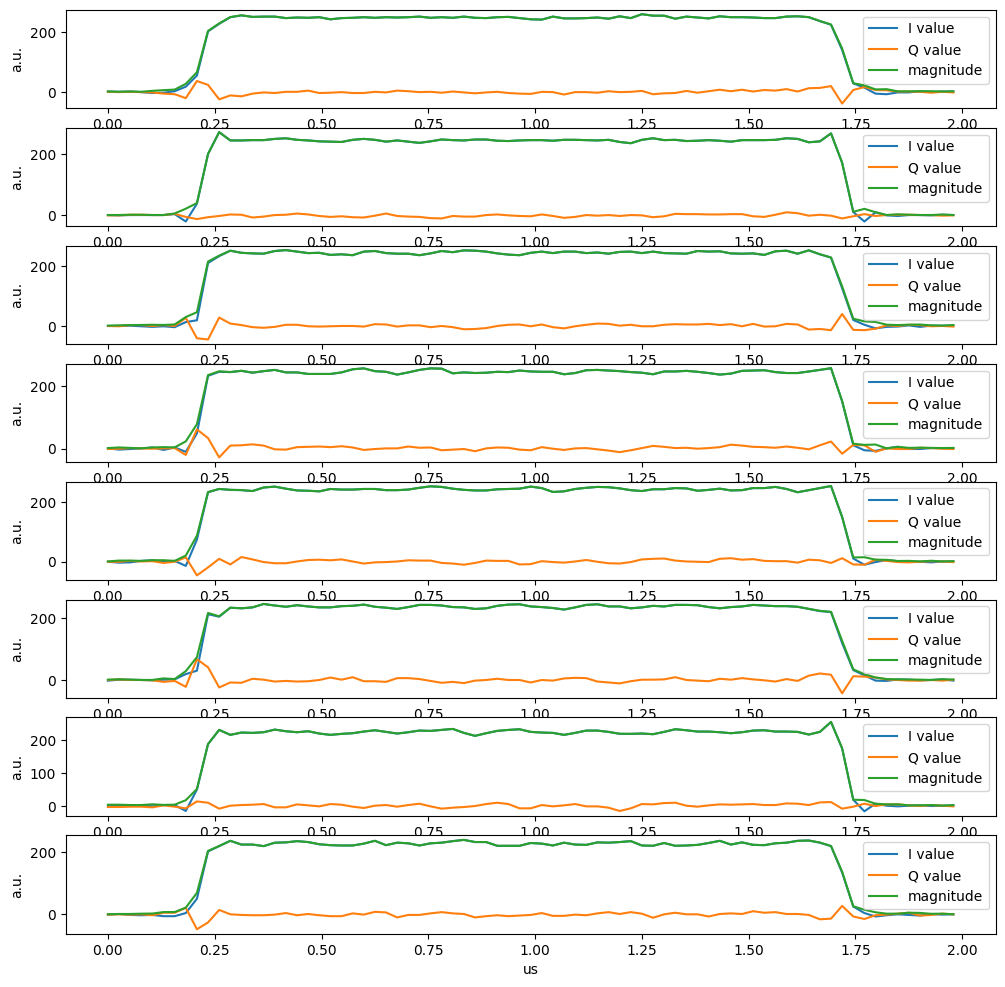

In [29]:
class MuxProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_chs = cfg['ro_chs']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'], ro_ch=ro_chs[0], 
                         mux_freqs=cfg['pulse_freqs'], 
                         mux_gains=cfg['pulse_gains'], 
                         mux_phases=cfg['pulse_phases'],
                         mixer_freq=cfg['mixer_freq'])
        for ch, f, ph in zip(cfg['ro_chs'], cfg['pulse_freqs'], cfg['ro_phases']):
            self.declare_readout(ch=ch, length=cfg['ro_len'], freq=f, phase=ph, gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="mymux", 
                       style="const", 
                       length=cfg["pulse_len"],
                       mask=[0,1,2,3,4,5,6,7],
                      )
        
    def _body(self, cfg):
        self.trigger(ros=cfg['ro_chs'], pins=[0], t=cfg['trig_time'], ddr4=True)
        self.pulse(ch=cfg['gen_ch'], name="mymux", t=0)
        
config = {'gen_ch': MIXMUXGEN_CH,
          'ro_chs': MUXRO_CH,
          'mixer_freq': 5000,
          'nqz': 2,
          'pulse_freqs': 5000+np.arange(8)*50,
          'pulse_gains': [1.0]*8,
          'pulse_phases': [0.0]*8,
          'ro_phases': [0.0]*8,
          'trig_time': 0.5,
          'pulse_len': 1.5,
          'ro_len': 2.0,
          # 'trig_time': 1.0,
          # 'pulse_len': 3.0,
          # 'ro_len': 2.5,
         }

prog = MuxProgram(soccfg, reps=1, final_delay=0.5, cfg=config)
iq_list = prog.acquire_decimated(soc, soft_avgs=1, progress=False)
t = prog.get_time_axis(ro_index=0)

phases = [np.angle(iq.mean(axis=0).dot([1,1j]), deg=True) for iq in iq_list]
print("phase offsets:", phases)
config['pulse_phases'] = [-x for x in phases]

prog = MuxProgram(soccfg, reps=1, final_delay=0.5, cfg=config)
iq_list = prog.acquire_decimated(soc, soft_avgs=1)
t = prog.get_time_axis(ro_index=0)

fig, axes = plt.subplots(len(config['ro_chs']), 1, figsize=(12,12))
for i, ch in enumerate(config['ro_chs']):
    plot = axes[i]
    plot.plot(t, iq_list[i][:,0], label="I value")
    plot.plot(t, iq_list[i][:,1], label="Q value")
    plot.plot(t, np.abs(iq_list[i].dot([1,1j])), label="magnitude")
    plot.legend()
    plot.set_ylabel("a.u.")
    plot.set_xlabel("us");

The pulse length and the tone set can be varied dynamically from pulse to pulse.

The tone frequency/amplitude/phase cannot be changed dynamically, and arbitrary envelopes cannot be used - the intended use for the multiplexed generator is readout, not control.

  0%|          | 0/1 [00:00<?, ?it/s]

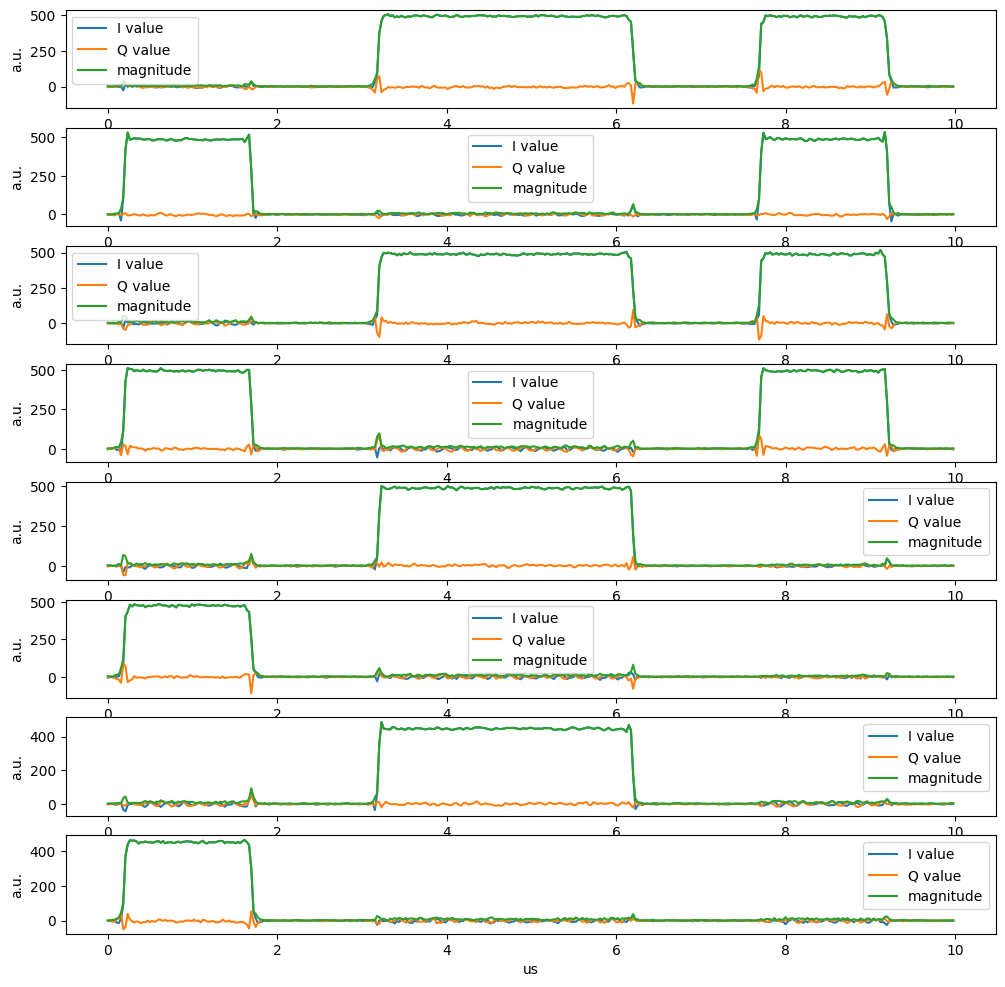

In [30]:
class MuxProgram2(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_chs = cfg['ro_chs']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'], ro_ch=ro_chs[0], 
                         mux_freqs=cfg['pulse_freqs'], 
                         mux_gains=cfg['pulse_gains'], 
                         mux_phases=cfg['pulse_phases'],
                         mixer_freq=cfg['mixer_freq'])
        for ch, f, ph in zip(cfg['ro_chs'], cfg['pulse_freqs'], cfg['ro_phases']):
            self.declare_readout(ch=ch, length=5*cfg['ro_len'], freq=f, phase=ph, gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="mymux1", 
                       style="const", 
                       length=cfg["pulse_len"],
                       mask=[1,3,5,7],
                      )

        self.add_pulse(ch=gen_ch, name="mymux2", 
                       style="const", 
                       length=2*cfg["pulse_len"],
                       mask=[0,2,4,6],
                      )

        self.add_pulse(ch=gen_ch, name="mymux3", 
                       style="const", 
                       length=1*cfg["pulse_len"],
                       mask=[0,1,2,3],
                      )

    def _body(self, cfg):
        self.trigger(ros=cfg['ro_chs'], pins=[0], t=cfg['trig_time'], ddr4=True)
        self.pulse(ch=cfg['gen_ch'], name="mymux1", t=0)
        self.pulse(ch=cfg['gen_ch'], name="mymux2", t=2*cfg["pulse_len"])
        self.pulse(ch=cfg['gen_ch'], name="mymux3", t=5*cfg["pulse_len"])

prog = MuxProgram2(soccfg, reps=1, final_delay=0.5, cfg=config)
iq_list = prog.acquire_decimated(soc, soft_avgs=1)
t = prog.get_time_axis(ro_index=0)

fig, axes = plt.subplots(len(config['ro_chs']), 1, figsize=(12,12))
for i, ch in enumerate(config['ro_chs']):
    plot = axes[i]
    plot.plot(t, iq_list[i][:,0], label="I value")
    plot.plot(t, iq_list[i][:,1], label="Q value")
    plot.plot(t, np.abs(iq_list[i].dot([1,1j])), label="magnitude")
    plot.legend()
    plot.set_ylabel("a.u.")
    plot.set_xlabel("us");

### Readout channelizer
The mux readout is based on a polyphase filter bank which divides the spectrum into 64 frequency channels.

We can get a better sense of how this works by taking FFTs of the output from each channel.

PFB Readout Parameters:
 -> fs                = 1228.8 MHz
 -> Channel Distance  = 19.2 MHz
 -> Channel Bandwidth = 38.4 MHz


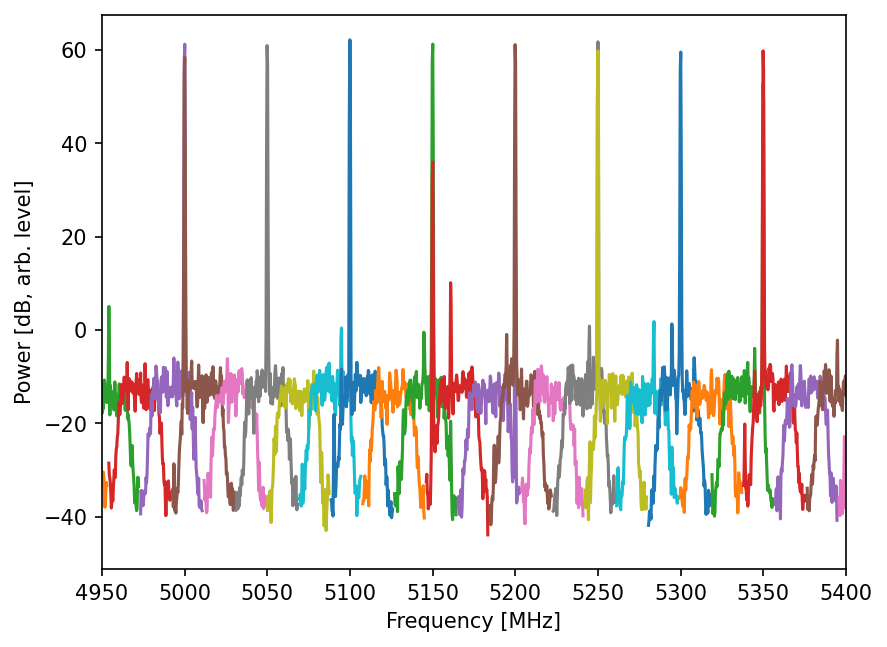

In [31]:
from numpy.fft import fftshift
from scipy.signal import welch

rocfg = soccfg['readouts'][MUXRO_CH[0]]
fs = rocfg['fs']/rocfg['decimation'] # total frequency span
N = rocfg['pfb_nch'] # number of PFB channels
M = rocfg['pfb_ch_offset']
fc_ch = fs/N # spacing between channel centers
fs_ch = rocfg['f_dds']
print("PFB Readout Parameters:")
print(" -> fs                = {} MHz".format(fs))
print(" -> Channel Distance  = {} MHz".format(fc_ch))
print(" -> Channel Bandwidth = {} MHz".format(fs_ch))

#################################
### PFB Channels Side-by-Side ###
#################################
class MuxChannelProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']

        freqs = cfg['pulse_freqs']

        # we intentionally don't use frequency matching:
        # we want the RO freqs to be exactly at the channel centers
        # and we don't actually care if the gen freqs are matched
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'],
                         mux_freqs=freqs, 
                         mux_gains=[cfg['pulse_gain']]*len(freqs), 
                         mux_phases=[0.0]*len(freqs),
                         mixer_freq=cfg['mixer_freq'])
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['ro_freq'], phase=0)

        self.add_pulse(ch=gen_ch, name="mymux", 
                       style="const", 
                       length=cfg["pulse_len"],
                       mask=[0,1,2,3,4,5,6,7],
                      )
        
    def _body(self, cfg):
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], ddr4=True)
        self.pulse(ch=cfg['gen_ch'], name="mymux", t=0)
        
config = {'gen_ch': MIXMUXGEN_CH,
          'ro_ch': MUXRO_CH[0],
          'nqz': 2,
          'mixer_freq': 5000,
          'pulse_freqs': 5000+np.arange(8)*50,
          'pulse_gain': 0.1,
          'trig_time': 1.0,
          'pulse_len': 26.0,
          'ro_len': 25.5,
         }

# Frequency and amplitude vectors.
complex_iq = []
# Loop over channel centers.
foffset = 0*fs_ch/4
fc_v = np.arange(0, fs, fc_ch) + foffset + rocfg['fs']*2
for fck in fc_v:
    # Update frequency.
    config['ro_freq'] = fck
    
    # Get data from channel.
    prog = MuxChannelProgram(soccfg, reps=1, final_delay=0.5, cfg=config)
    
    iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=False, remove_offset=True)
    complex_iq.append(iq_list[0].dot([1,1j]))
    
fig, ax = plt.subplots(1, dpi=150);
for fck, x in zip(fc_v, complex_iq):
    fft_freqs, psd = fftshift(welch(x, fs_ch, return_onesided=False, nperseg=128, detrend=False), axes=1)
    # we drop the FFT points at the ends of the range
    ax.plot(fft_freqs[2:-1]+fck, 20*np.log10(psd[2:-1]))

ax.set_xlabel("Frequency [MHz]");
ax.set_ylabel("Power [dB, arb. level]");   
ax.set_xlim(4950,5400);

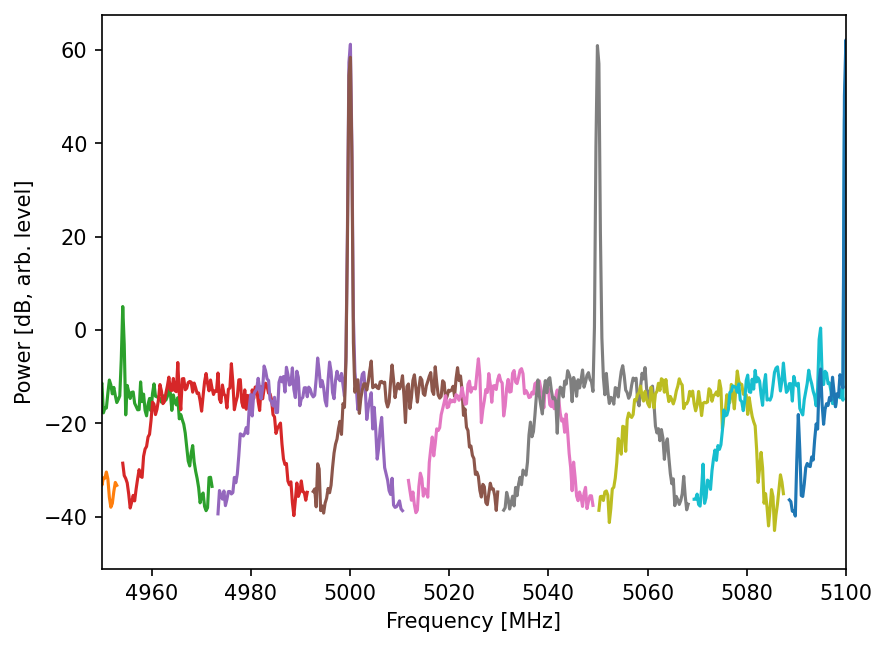

In [32]:
ax.set_xlim(4950,5100)
fig

  0%|          | 0/1 [00:00<?, ?it/s]

phase delay -0.6827 us


  0%|          | 0/100010 [00:00<?, ?it/s]

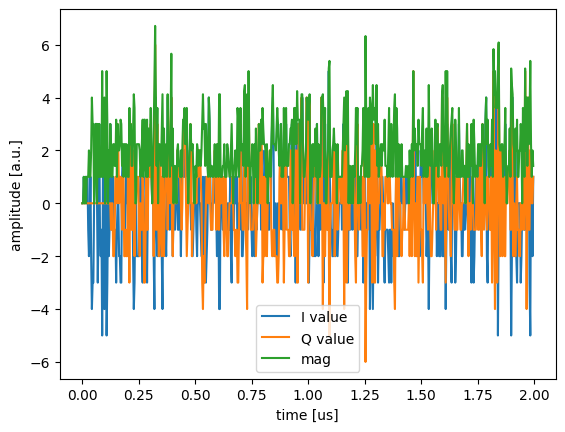

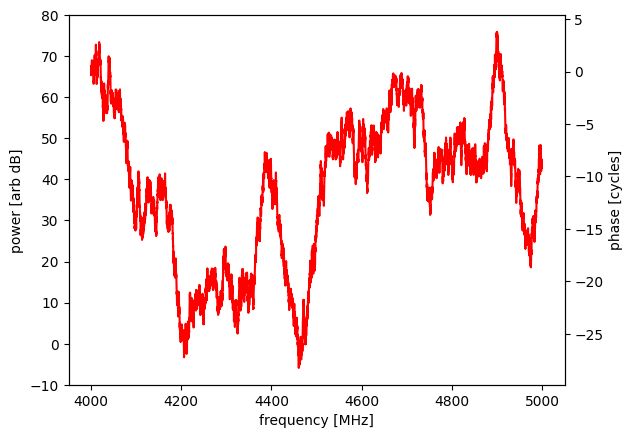

In [33]:
# freq sweep with int4

class FreqSweepProgram2(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'], mixer_freq=5000)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        # we need to make sure the readout gets reconfigured at the start of each frequency step
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch)
        loopbefore = AsmV2()
        # if you delay the config by too long, you can see the readout get reconfigured in the middle of your pulse
        loopbefore.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)

        self.add_loop("myloop", self.cfg["steps"], exec_before=loopbefore)

        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
                       style="const", 
                       freq=cfg['freq'], 
                       length=cfg['pulse_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'], 
                      )
        
    def _body(self, cfg):
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

CAL_FREQ = 5000
CAL_RANGE = 0.1

# plot decimated to show that we're timed in
config = {'steps': 1,
          'gen_ch': 14,
          'ro_ch': DYNRO_CH[1],
          'freq': CAL_FREQ,
          'nqz': 1,
          'trig_time': 0.2,
          'ro_len': 2,
          'pulse_len': 1.5,
          'phase': 0,
          'gain': 1.0,
         }

prog = FreqSweepProgram2(soccfg, reps=1, final_delay=1.0, cfg=config)
iq_list = prog.acquire_decimated(soc, soft_avgs=1)
t = prog.get_time_axis(ro_index=0)

iq = iq_list[0]
plt.plot(t, iq[:,0], label="I value")
plt.plot(t, iq[:,1], label="Q value")
plt.plot(t, np.abs(iq.dot([1,1j])), label="mag")
plt.ylabel("amplitude [a.u.]")
plt.xlabel("time [us]")
plt.legend();

def fit_delay(freqs, iqs, initial_delay=0, debug=False):
    iq_complex = iqs.dot([1,1j])
    phases = np.unwrap(np.angle(iq_complex))/(2*np.pi)
    # apply the initial correction
    phases = phases - freqs*initial_delay
    if debug: print("phase step after initial correction (cycles):", phases[1]-phases[0])
    
    # plt.plot(freqs, phases)
    # plt.ylabel("Phase [cycles]")
    # plt.xlabel("Frequency [MHz]")
    
    a = np.vstack([freqs, np.ones_like(freqs)]).T
    phase_delay = np.linalg.lstsq(a, phases, rcond=None)[0][0]
    total_delay = initial_delay + phase_delay
    if debug: print("delay correction %.4f us, new delay %.4f us"%(phase_delay, total_delay))
    return total_delay

# increase the pulse and RO length for more efficient measurement, and put the RO window inside the pulse
config['trig_time']+=0.5
config['pulse_len'] = 10
config['ro_len'] = 9.5

config['steps']=1001
config['freq'] = QickSweep1D("myloop",  CAL_FREQ, CAL_FREQ+CAL_RANGE)
prog = FreqSweepProgram2(soccfg, reps=10, final_delay=1.0, cfg=config)
freqs = prog.get_pulse_param('myro', 'freq', as_array=True)
iq_list = prog.acquire(soc, soft_avgs=1, progress=False)
delay_cal = fit_delay(freqs, iq_list[0][0], debug=False)

config['steps']=1001
config['freq'] = QickSweep1D("myloop",  CAL_FREQ, CAL_FREQ+100*CAL_RANGE)
prog = FreqSweepProgram2(soccfg, reps=10, final_delay=1.0, cfg=config)
freqs = prog.get_pulse_param('myro', 'freq', as_array=True)
iq_list = prog.acquire(soc, soft_avgs=1, progress=False)
delay_cal = fit_delay(freqs, iq_list[0][0], debug=False, initial_delay=delay_cal)
print("phase delay %.4f us"%(delay_cal))

config['freq'] = QickSweep1D("myloop", 4000, 5000)
config['steps'] = 10001
config['nqz'] = 1

prog = FreqSweepProgram2(soccfg, reps=10, final_delay=1.0, cfg=config)
freqs = prog.get_pulse_param('myro', 'freq', as_array=True)
iq_list = prog.acquire(soc, soft_avgs=1, progress=True)
iq_complex = iq_list[0][0].dot([1,1j])

iq_rotated = iq_complex*np.exp(-1j*freqs*2*np.pi*delay_cal)

phases_corrected = np.unwrap(np.angle(iq_rotated))/(2*np.pi)
powers = 20*np.log10(np.abs(iq_rotated))

fig = plt.figure()
plt.plot(freqs, powers, label="amplitude [dB]")
plot = fig.axes[0]
ax2 = plot.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(freqs, phases_corrected, color='red', label='phase')

plot.set_ylim((-10, 80))
plot.set_ylabel("power [arb dB]")
plot.set_xlabel("frequency [MHz]")
ax2.set_ylabel("phase [cycles]");

In [34]:
# check DDR4 on mux RO


# MIXMUXGEN_CH = 12
# MUXRO_CH = [2,3,4,5,6,7,8,9]

# class MuxProgram(AveragerProgramV2):
#     def _initialize(self, cfg):
#         ro_chs = cfg['ro_chs']
#         gen_ch = cfg['gen_ch']
        
#         self.declare_gen(ch=gen_ch, nqz=1, ro_ch=ro_chs[0], 
#                          mux_freqs=cfg['pulse_freqs'], 
#                          mux_gains=cfg['pulse_gains'], 
#                          mux_phases=cfg['pulse_phases'],
#                          mixer_freq=cfg['mixer_freq'])
#         for ch, f, ph in zip(cfg['ro_chs'], cfg['pulse_freqs'], cfg['ro_phases']):
#             self.declare_readout(ch=ch, length=cfg['ro_len'], freq=f, phase=ph, gen_ch=gen_ch)

#         self.add_pulse(ch=gen_ch, name="mymux", 
#                        style="const", 
#                        length=cfg["pulse_len"],
#                        mask=[0,1,2,3,4,5,6,7],
#                       )
#         self.trigger(ddr4=True, mr=True, t=0)
        
#     def _body(self, cfg):
#         self.trigger(ros=cfg['ro_chs'], pins=[0], t=cfg['trig_time'], ddr4=True)
#         self.pulse(ch=cfg['gen_ch'], name="mymux", t=0)
        
# config = {'gen_ch': MIXMUXGEN_CH,
#           'ro_chs': MUXRO_CH,
#           'mixer_freq': 5000,
#           'pulse_freqs': 5000+np.arange(8)*50,
#           'pulse_gains': [1.0]*8,
#           'pulse_phases': [0.0]*8,
#           'ro_phases': [0.0]*8,
#           'trig_time': 0.4,
#           'pulse_len': 1.0,
#           'ro_len': 1.9,
#          }

# prog = MuxProgram(soccfg, reps=10, final_delay=0.5, cfg=config)
# soc.arm_ddr4(ch=MUXRO_CH[0], nt=100)

# iq_list = prog.acquire(soc, soft_avgs=1)

# # iq_list = prog.acquire_decimated(soc, soft_avgs=1)
# # t = prog.get_time_axis(ro_index=0)

# # fig, axes = plt.subplots(len(config['ro_chs']), 1, figsize=(12,12))
# # for i, ch in enumerate(config['ro_chs']):
# #     plot = axes[i]
# #     plot.plot(t, iq_list[i][:,0], label="I value")
# #     plot.plot(t, iq_list[i][:,1], label="Q value")
# #     plot.plot(t, np.abs(iq_list[i].dot([1,1j])), label="magnitude")
# #     plot.legend()
# #     plot.set_ylabel("a.u.")
# #     plot.set_xlabel("us");

# iq_ddr4 = soc.get_ddr4(10)
# t = prog.get_time_axis_ddr4(MUXRO_CH[0], iq_ddr4)

# plt.plot(t, iq_ddr4[:,0],label="I")
# plt.plot(t, iq_ddr4[:,1],label="Q")
# # plt.plot(np.abs(iq_ddr4.dot([1,1j])),label="mag")
# plt.xlabel("us")
# # plt.xlim((0,5))
# plt.legend();

In [35]:
from qick.asm_v2 import QickProgramV2, Waveform

prog = QickProgramV2(soccfg)
# add an empty waveform that we can play with
prog.add_raw_pulse("mypulse", [Waveform(0,0,0,0,0,0)])
prog.delay(1.0)
for wname in prog.list_pulse_waveforms("mypulse"):
    prog.read_wmem(name=wname)
    prog.write_wmem(name=wname)
prog.end()

# prog = QickProgramV2(soccfg)
# prog.asm_inst({'CMD': 'TIME', 'C_OP': 'inc_ref', 'LIT': '#384'})
# prog.asm_inst({'CMD': 'REG_WR', 'DST': 'r_wave', 'SRC': 'wmem', 'ADDR': '&0'})
# prog.asm_inst({'CMD': 'WMEM_WR', 'DST': '[&0]'})
# prog.end()

prog.compile()
# convert text ASM to ASM dicts
print("\nASM dicts:")
# plist,labels = Assembler.str_asm2list(pstr)
for a in prog.prog_list:
    print(a)
    
# print("\nlabels:")
# for a in prog.labels.items():
#     print(a)
    
print("\ntext ASM:")
print(prog.asm())

print("machine code:")
for a in prog.binprog['pmem']:
    print([hex(b) for b in a])


ASM dicts:
{'P_ADDR': 1, 'LINE': 2, 'CMD': 'NOP'}
{'CMD': 'TIME', 'C_OP': 'inc_ref', 'LIT': '#430', 'P_ADDR': 1, 'LINE': 2}
{'CMD': 'REG_WR', 'DST': 'r_wave', 'SRC': 'wmem', 'ADDR': '&0', 'P_ADDR': 2, 'LINE': 3}
{'CMD': 'WMEM_WR', 'DST': '&0', 'P_ADDR': 3, 'LINE': 4}
{'CMD': 'JUMP', 'ADDR': '&4', 'P_ADDR': 4, 'LINE': 5}

text ASM:
     NOP 
     TIME #430 inc_ref 
     REG_WR r_wave wmem [&0] 
     WMEM_WR &0 
     JUMP HERE 

machine code:
['0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0']
['0xd700', '0x8000000', '0x4c', '0x0', '0x0', '0x0', '0x0', '0x0']
['0x0', '0x40000000', '0x9c', '0x0', '0x0', '0x0', '0x0', '0x0']
['0x0', '0x40000000', '0xbe', '0x0', '0x0', '0x0', '0x0', '0x0']
['0x0', '0x8000', '0x3c', '0x0', '0x0', '0x0', '0x0', '0x0']
